### OPES and Implementation in Toy Model

This post is largely inspired by the materials in [3rd i-CoMSE Workshop](https://github.com/icomse/3rd_workshop_advanced_sampling), [paper for OPES](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00497) and [PLUMED implementaion of OPES](https://arxiv.org/abs/2410.18019)

Prerequisite: Basic Molecular Dynamics, Thermodynamics, Probability Theory.

---

#### Sampling

As discussed in the previous post, if we are able to sample configurations from a given ensemble, we can estimate the expectation value of any observable as well as the free energy profile along any collective variable (CV). The most common approaches for sampling are **Molecular Dynamics (MD)** and **Monte Carlo (MC)**. To keep things simple, we will focus on one MC method called **Markov Chain Monte Carlo (MCMC)** and apply it to a toy one-dimensional potential.

The idea of MCMC is to construct a Markov chain whose stationary distribution $\pi(x)$ matches the target distribution $p(x)$ we want to sample. In molecular simulations, this target distribution is the **Boltzmann distribution**:

$$
p(x) = \frac{\mathrm{e}^{-\beta U(x)}}{Z}
$$

There are many ways to construct a valid Markov chain. A sufficient (though not necessary) condition is to enforce **detailed balance**, which requires

$$
p(x_i)\, T_{x_i \rightarrow x_j} = p(x_j)\, T_{x_j \rightarrow x_i},
$$

where $T_{x_i \rightarrow x_j}$ is the transition probability from state $x_i$ to $x_j$. Intuitively, this means that the probability flow from $x_i$ to $x_j$ is balanced by the reverse flow, ensuring $p(x)$ remains stationary.

Assuming the Boltzmann distribution is the stationary distribution, we can write the ratio of transition probabilities as

$$
\frac{T_{x_i \rightarrow x_j}}{T_{x_j \rightarrow x_i}} = \frac{p(x_j)}{p(x_i)} = \mathrm{e}^{-\beta \left(U(x_j) - U(x_i)\right)}.
$$

Any transition rule that satisfies this relation will preserve detailed balance. A common strategy is to decompose the transition into two parts: a **proposal** and an **acceptance-rejection** step:

$$
T_{x_i \rightarrow x_j} = g(x_i \rightarrow x_j)\, A(x_i \rightarrow x_j),
$$

where $g(x_i \rightarrow x_j)$ is the probability of proposing state $x_j$ given $x_i$, and $A(x_i \rightarrow x_j)$ is the probability of accepting the proposed move.

When the proposal is **symmetric**, i.e., $g(x_i \rightarrow x_j) = g(x_j \rightarrow x_i)$, we obtain the well-known **Metropolis algorithm**:

$$
\frac{T_{x_i \rightarrow x_j}}{T_{x_j \rightarrow x_i}} = \frac{A(x_i \rightarrow x_j)}{A(x_j \rightarrow x_i)} = \frac{p(x_j)}{p(x_i)} = \mathrm{e}^{-\beta \left(U(x_j) - U(x_i)\right)}.
$$

We claim that the following **acceptance rule** satisfies this condition:

$$
A(x_i \rightarrow x_j) = \min \left\{1,\, \mathrm{e}^{-\beta \left(U(x_j) - U(x_i)\right)} \right\}.
$$

To verify this, consider two cases:

- If $U(x_j) < U(x_i)$, then
  $$
  \frac{A(x_i \rightarrow x_j)}{A(x_j \rightarrow x_i)} = \frac{1}{\mathrm{e}^{-\beta (U(x_i) - U(x_j))}} = \mathrm{e}^{-\beta (U(x_j) - U(x_i))}.
  $$

- If $U(x_j) > U(x_i)$, then
  $$
  \frac{A(x_i \rightarrow x_j)}{A(x_j \rightarrow x_i)} = \frac{\mathrm{e}^{-\beta (U(x_j) - U(x_i))}}{1} = \mathrm{e}^{-\beta (U(x_j) - U(x_i))}.
  $$

In both cases, detailed balance holds.  
Thus, using this acceptance criterion, we can correctly sample from the **Boltzmann distribution** via MCMC.

The implementation of MCMC is extermely simple, see the following code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mcmc(x0, T, potential, std=1.0):
    """MCMC sampling algorithm.

    Args:
        x0: initial state
        T: temperature
        potential: potential energy function
        std: standard derivation for the proposed state. Defaults to 1.0.
    """
    x_new = x0 + np.random.normal(0, std) # a symmetric proposal
    delta_E = potential(x_new) - potential(x0)
    
    if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
        return x_new
    else:
        return x0

#### 1D double-well potential
We now define a double-well potential to see if MCMC can correctly sample from that. The potential if taken from https://github.com/icomse/3rd_workshop_advanced_sampling/blob/main/Monday/toy_model_for_sampling.ipynb

In [3]:
#define the potential - these can be altered.
mean1 = 1.0  # center of first minima
mean2 = 9.0  # center of 2nd minima
cut1 = 4.0   # start of transition region
cut2 = 6.0   # end of transition region
const1 = 0.0  # value at bottom of  first minima
const2 = -2.0 # value at bottom of second minima
barrier = 60.0 # the value at (cut1+cut2)/2   # Barrier height
k1 = 5 # spring contstant of first minima
k2 = 5 # spring constant of 2nd minima

def lower_pot(x):
    pot = k1*(x-mean1)**2 + const1  # Harmonic!
    return pot

def upper_pot(x):
    pot = k2*(x-mean2)**2 + const2  # Harmonic
    return pot

def interpolate_pot(x):
    x1 = cut1
    x2 = cut2
    x3 = (cut1+cut2)/2
    y1 = lower_pot(cut1)
    y2 = upper_pot(cut2)
    y3 = barrier
    # lagrange interpolation formula for the potential barrier is
    return y1*(x-x2)*(x-x3)/((x1-x2)*(x1-x3)) + y2*(x-x1)*(x-x3)/((x2-x1)*(x2-x3)) + y3*(x-x1)*(x-x2)/((x3-x1)*(x3-x2))

def potential(x):
    # define it as a piecewise potential to make it possible to vectorize.
    return np.piecewise(x,[x<cut1,x>cut2],[lower_pot,upper_pot,interpolate_pot])

The potential exhibits two minima at positions 1 and 9, with a barrier height of 60 separating them.

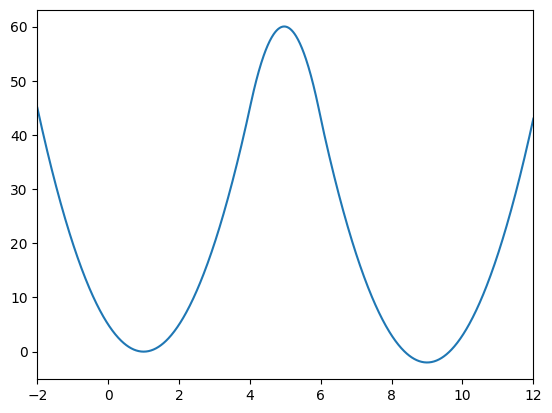

In [4]:
x = np.linspace(-2, 12, 1000)
plt.plot(x,potential(x))
plt.xlim([-2, 12])
plt.show()

Let's plot the Boltzmann distribution and free energy of this potential at different temperature

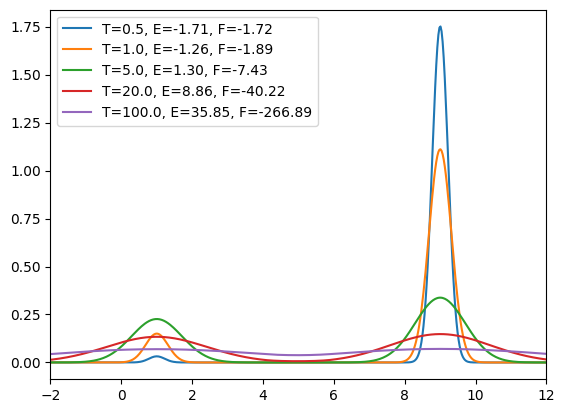

In [5]:
x = np.linspace(-10, 20, 1000)
Ts = [0.5, 1.0, 5.0, 20.0, 100.0]  # different temperatures
Es = [] # store average potential energies
Fs = [] # store free energies

for T in Ts:
    distribution = np.exp(-potential(x)/T)
    Z = np.trapezoid(distribution, x) # partition function
    P = distribution / Z  # Boltzmann distribution
    E = np.trapezoid(P * potential(x), x)  # Average energy
    F = -T * np.log(Z)  # Free energy
    Es.append(E)
    Fs.append(F)
    plt.plot(x, P, label=f'T={T}, E={E:.2f}, F={F:.2f}')

plt.xlim([-2, 12])
plt.legend()
plt.show()

There are some interesting observations:

- **At low temperature**, the probability distribution is sharply peaked around the lowest minimum (i.e., near $x = 9$). The system predominantly stays in this state since transitions to higher-energy regions are highly unlikely.  
- **At low temperature**, the average potential energy is approximately equal to the free energy. This is because, by definition, the free energy is the potential energy minus an entropy term:

  $$
  F = U - TS
  $$

  At low temperature, the entropy contribution ($TS$) is small since only the ground state significantly contributes, making the free energy effectively dominated by the potential energy.
- **At moderate temperature**, the probability becomes comparable at both minima. However, transitions between them remain rare because the probability in the barrier region between the two minima is close to zero.  
- **At extremely high temperature**, the probability distribution approaches a uniform shape, indicating that energy barriers become irrelevant and all configurations are equally likely to be sampled.

Let's run a mcmc to see if it can correctly sample the Boltzmann distribution and calculate the observable (average potential energy).


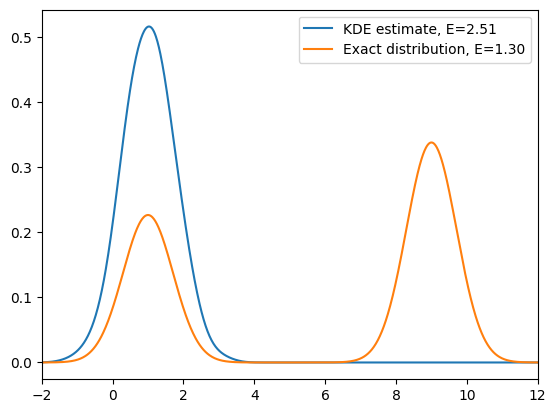

In [6]:
from sklearn.neighbors import KernelDensity # We will use KDE to estimate the distribution

n_step = 10000
T = 5.0

xs = []
x = 1.0  # initial state
xs.append(x)

Es = []  # store potential energies
for step in range(n_step):
    x = mcmc(x, T, potential)
    xs.append(x)
    Es.append(potential(x))

kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1))
x_d = np.linspace(-2, 12, 1000)
log_dens = kde.score_samples(x_d.reshape(-1, 1))
E_avg = np.mean(Es)
plt.plot(x_d, np.exp(log_dens), label=f'KDE estimate, E={E_avg:.2f}')

# Compare with the exact distribution
distribution = np.exp(-potential(x_d)/T)
Z = np.trapezoid(distribution, x_d) # partition function
P = distribution / Z  # Boltzmann distribution
E = np.trapezoid(P * potential(x_d), x_d)  # Average energy
plt.plot(x_d, P, label=f'Exact distribution, E={E:.2f}')
plt.xlim([-2, 12])
plt.legend()
plt.show()

As we can see from the above simulation, at **relatively low temperature**, if we start in one energy minimum, standard MCMC often **fails to recover the full Boltzmann distribution**: the chain remains trapped in a single basin and **cannot cross the energy barrier**. As a result, we only sample one minimum and obtain biased estimates of observables.

You can increase the temperature to observe how the sampling behavior changes. Typically, by **increasing the temperature**, we effectively lower the relative height of the energy barrier, allowing the system to more easily transition between minima. As a result, the MCMC sampler can explore both basins, recover the **true Boltzmann distribution**, and produce the **correct expectation values**.

This observation motivates the idea of **Replica Exchange (RE)**, also known as **Parallel Tempering**. The key idea is that, instead of running a single simulation at a low temperature (which easily gets trapped but is of our primary interest), we **run multiple replicas** of the system at **different temperatures** simultaneously where high-temperature replicas can explore the configuration space more freely. By **occasionally exchanging configurations** between replicas, we allow the low-temperature systems to escape local minima and achieve proper sampling across the entire configurational space.

I will not go into too much detail about Replica Exchange in this post. Instead, let’s recall from the previous discussion that **importance sampling** allows us to sample from a simpler distribution and still recover the original target distribution through reweighting. Could this idea help us here as well? For the proposal distribution, we will use the **well-tempered distribution** $p^{\mathrm{WT}}$, which aims to broaden the equilibrium distribution:

$$
p^{\mathrm{WT}} \propto [p]^{1/\gamma},
$$

where the parameter $\gamma$ (known as the **bias factor**) controls the degree of smoothing. The well-tempered distribution can be interpreted as an effective Boltzmann distribution at a temperature $\gamma$ times higher than the original one, resulting in broader sampling while maintaining good overlap with the true Boltzmann distribution. In the limit of $\gamma \to \infty$, the well-tempered distribution will approach to a uniform distribution.

Meanwhile, the free energy barrier is reduced by a factor of $\gamma$, which can be shown as follows:

$$
\begin{aligned}
F^{\mathrm{WT}}(\theta) 
&= -\frac{1}{\beta} \ln \int \mathrm{e}^{-\frac{\beta}{\gamma} U(x)} \, \delta(\theta - \theta(\mathbf{x})) \, \mathrm{d}\mathbf{x} \\[6pt]
&= -\frac{1}{\beta} \ln \left[ \int \mathrm{e}^{-\beta U(x)} \, \delta(\theta - \theta(\mathbf{x})) \, \mathrm{d}\mathbf{x} \right]^{\frac{1}{\gamma}} \\[6pt]
&= -\frac{1}{\gamma \beta} \ln \int \mathrm{e}^{-\beta U(x)} \, \delta(\theta - \theta(\mathbf{x})) \, \mathrm{d}\mathbf{x} \\[6pt]
&= \frac{1}{\gamma} F(\theta).
\end{aligned}
$$

Thus, the well-tempered distribution effectively **flattens the free energy landscape** by scaling down the energy barriers, facilitating transitions between metastable states while preserving the essential thermodynamic structure of the system.



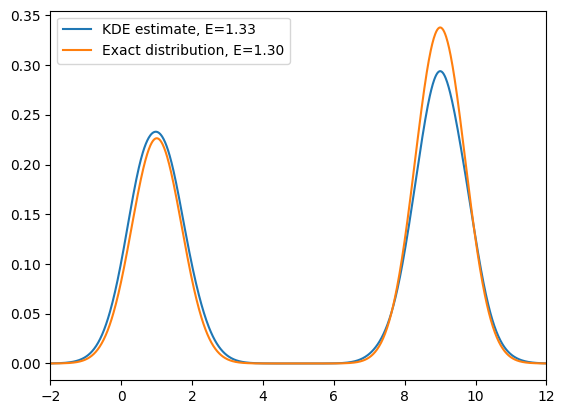

In [15]:
T = 5.0
gamma = 10.0 # bias factor
xs = [] # store samples
x = 1.0 # initial state

Es = [] # store potential energies
weights = [] # store weights = p/p^WT
for step in range(n_step):
    x = mcmc(x, T * gamma, potential)  # note the temperature is scaled by gamma
    xs.append(x)
    Es.append(potential(x))
    weights.append(np.exp(-(1 - 1/gamma) * potential(x) / T))  # weight for reweighting

kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1), sample_weight=weights)
x_d = np.linspace(-2, 12, 1000)
log_dens = kde.score_samples(x_d.reshape(-1, 1))
E_avg = np.average(Es, weights=weights)
plt.plot(x_d, np.exp(log_dens), label=f'KDE estimate, E={E_avg:.2f}')

# Compare with the exact distribution
distribution = np.exp(-potential(x_d)/T)
Z = np.trapezoid(distribution, x_d) # partition function
P = distribution / Z # Boltzmann distribution
E = np.trapezoid(P * potential(x_d), x_d)  # Average
plt.plot(x_d, P, label=f'Exact distribution, E={E:.2f}')
plt.xlim([-2, 12])
plt.legend()
plt.show()

This looks promising: if we run a simulation at a **higher temperature** and then **reweight**, we can in principle recover the original distribution. However, this works neatly only for the **1D toy model**. Why?

- In high-dimensional systems, heating **accelerates all degrees of freedom**, not just the chosen CV. The orthogonal coordinates then explore regions that have **poor overlap** with the low-temperature Boltzmann measure, making reweighting **statistically unstable** (the weights become extremely skewed).
- Practically, we only want to **accelerate sampling along a chosen CV** while leaving the **orthogonal modes near equilibrium**, so that reweighting remains efficient and observables are not contaminated by hot, irrelevant motions.

This motivates **on-the-fly probability enhanced sampling (OPES)**. The idea is to **bias only the chosen CV** towards a target distribution $p^{\mathrm{tg}}(\theta)$ (e.g. the well-tempered distribution), while leaving the orthogonal degrees of freedom largely unaffected.

For any CV $\theta$, its unbiased distribution is
$$
p(\theta) = \frac{1}{Z} \int \mathrm{e}^{-\beta U(\mathbf{x})}\,\delta\!\big(\theta-\theta(\mathbf{x})\big)\,\mathrm{d}\mathbf{x}.
$$

We now **apply a CV-dependent bias** $V(\theta)$ chosen as
$$
V(\theta) = \frac{1}{\beta}\,\log\frac{p(\theta)}{p^{\mathrm{tg}}(\theta)}.
$$

Let $p'(\theta)$ denote the **biased** distribution. Then
$$
\begin{aligned}
p'(\theta)
&= \frac{1}{Z'} \int \exp\!\left[-\beta\Big(U(\mathbf{x})+V(\theta(\mathbf{x}))\Big)\right] \,
\delta\!\big(\theta-\theta(\mathbf{x})\big)\,\mathrm{d}\mathbf{x} \\[4pt]
&= \frac{1}{Z'} \int \left(\mathrm{e}^{-\beta U(\mathbf{x})}\cdot \frac{p^{\mathrm{tg}}(\theta)}{p(\theta)}\right)
\delta\!\big(\theta-\theta(\mathbf{x})\big)\,\mathrm{d}\mathbf{x} \\[4pt]
&= \frac{p^{\mathrm{tg}}(\theta)}{Z'\,p(\theta)} \int \mathrm{e}^{-\beta U(\mathbf{x})}\,
\delta\!\big(\theta-\theta(\mathbf{x})\big)\,\mathrm{d}\mathbf{x} \\[4pt]
&= \frac{p^{\mathrm{tg}}(\theta)}{Z'\,p(\theta)} \, Z\, p(\theta) \quad (\text{using the definition of } p(\theta)) \\[4pt]
&\propto p^{\mathrm{tg}}(\theta).
\end{aligned}
$$
Since $Z'$ is a normalization constant, this implies $p'(\theta)=p^{\mathrm{tg}}(\theta)$ after normalization.

If we choose the **well-tempered target**
$$
p^{\mathrm{tg}}(\theta) \propto \big[p(\theta)\big]^{1/\gamma},
$$
then the corresponding bias is
$$
V(\theta) \;=\; \frac{1}{\beta}\log\frac{p(\theta)}{p^{\mathrm{tg}}(\theta)}
\;=\; \Big(1-\tfrac{1}{\gamma}\Big)\frac{1}{\beta}\log p(\theta)
\;=\; -\Big(1-\tfrac{1}{\gamma}\Big)\,F(\theta).
$$

Thus, **in the limit of convergence**, the applied bias directly yields the free-energy profile:
$F(\theta) = -\frac{1}{1-1/\gamma}\,V(\theta)$ (up to an additive constant).

The remaining practical question is: *after applying the bias, how do we obtain the unbiased $p(\theta)$?*  
As discussed in the [previous post](https://cytwyatt.github.io/blog/2025/enhanced-sampling2/), we can **estimate $p(\theta)$ on the fly via reweighting**. In practice, **OPES** proceeds iteratively:

1. **Update** the on-the-fly estimate $p_n(\theta)$ by **weighted KDE**.  
2. **Update** the bias $V_n(\theta)$.  
3. **Sample** with the updated bias to generate new data and repeat.

In implementations, one typically adds a small regularization to avoid $\,\log 0\,$ and **updates the bias smoothly** to ensure stability in the early stages. A practical update at iteration $n$ is

$$
V_n(\theta)
= \left(1-\frac{1}{\gamma}\right)\frac{1}{\beta}
\log\!\left(\frac{p_n(\theta)}{Z_n}+\epsilon\right),
$$

where:
- $p_n(\theta)$ is the current on-the-fly estimate of the CV distribution,
- $Z_n = \frac{1}{|\Omega|} \int_{\Omega} p_n(\theta) \, \mathrm{d}\theta$ normalizes $p_n$ over explored region of CV space,
- $\epsilon>0$ is a small regularization term to prevent numerical issues.

Meanwhile, for the KDE algorithm, the computational cost increases with the number of kernels, since each new sample contributes an additional kernel to the density estimate. As a result, the evaluation of $p(\theta)$ becomes progressively slower as the simulation proceeds. To address this, practical implementations often employ a **kernel merging** or **compression** algorithm that combines nearby kernels to maintain a manageable number without sacrificing accuracy. However, for the sake of clarity and illustration, we will not use this optimization here.


Let's try to implement OPES on this toy model.

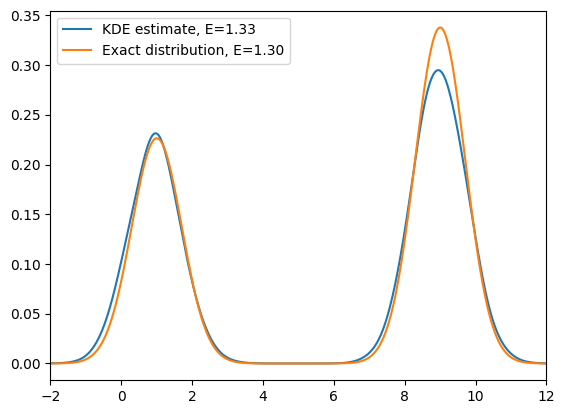

In [21]:
T = 5.0
gamma = 30.0 # bias factor
iters = 100  # number of iterations
n_sample = 100  # number of samples per iteration
epsilon = 1e-10
xs = [] # store samples
x = 1.0 # initial state
Es = [] # store potential energies
weights = [] # store weights

def bias(x):
    x2d = np.atleast_1d(x).reshape(-1, 1)
    log_p = kde.score_samples(x2d)
    p_est = np.exp(log_p)
    V = (1.0 - 1.0/gamma) * T * np.log(p_est + epsilon)
    return V if x2d.shape[0] > 1 else V[0]

def potential_biased(x):
    return potential(x) + bias(x)

# initialization
for step in range(n_sample):
    x = mcmc(x, T, potential)
    xs.append(x)
    Es.append(potential(x))
    weights.append(1)  # weight for reweighting
kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1), sample_weight=weights)
xs = []
Es = []
weights = []

for i in range(iters):
    # 1. Sample
    for step in range(n_sample):
        # show biaed potential
        x = mcmc(x, T, potential_biased)  # note the temperature is scaled by gamma
        xs.append(x)
        Es.append(potential(x))
        weights.append(np.exp(bias(x)/T))  # weight for reweighting
    
    # 2. Update
    kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1), sample_weight=weights)

x_d = np.linspace(-2, 12, 1000)
log_dens = kde.score_samples(x_d.reshape(-1, 1))
E_avg = np.average(Es, weights=weights)
plt.plot(x_d, np.exp(log_dens), label=f'KDE estimate, E={E_avg:.2f}')

# Compare with the exact distribution
distribution = np.exp(-potential(x_d)/T)
Z = np.trapezoid(distribution, x_d) # partition function
P = distribution / Z # Boltzmann distribution
E = np.trapezoid(P * potential(x_d), x_d)  # Average
plt.plot(x_d, P, label=f'Exact distribution, E={E:.2f}')
plt.xlim([-2, 12])
plt.legend()
plt.show()


The free energy profile can be obtained either from **reweighting** or directly from the **quasi-static bias**:

$$
F(\theta) = -\frac{1}{\beta} \ln p(\theta)
\quad \text{or} \quad
F(\theta) = -\frac{1}{1 - \frac{1}{\gamma}}V(\theta).
$$

Both expressions are equivalent in the limit of convergence.


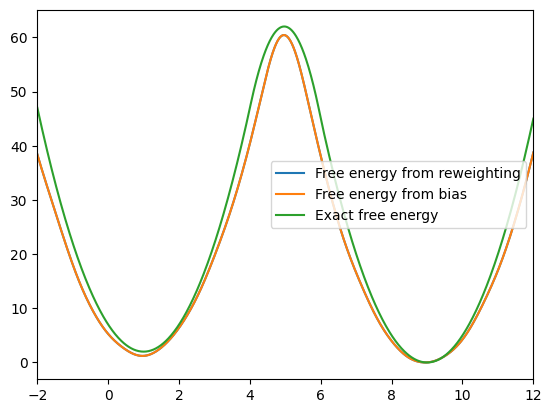

In [23]:
x_d = np.linspace(-2, 12, 1000)
log_dens = kde.score_samples(x_d.reshape(-1, 1))
F_reweight = -np.log(np.exp(log_dens)) * T
F_reweight -= F_reweight.min()  # shift to zero

F_bias = -1 / (1 - 1 / gamma) * bias(x_d)
F_bias -= F_bias.min()  # shift to zero

F_exact = potential(x_d)
F_exact -= F_exact.min()  # shift to zero

plt.plot(x_d, F_reweight, label='Free energy from reweighting')
plt.plot(x_d, F_bias, label='Free energy from bias')
plt.plot(x_d, F_exact, label='Exact free energy')
plt.xlim([-2, 12])
plt.legend()
plt.show()

We can see that these two free energy estimates are consistent with each other and both closely match the exact free energy profile. Next, let’s examine how the **bias potential** and the **estimated probability distribution** evolve over the course of the iterations:


In [ ]:
# make GIF to illustrate the evolution of OPES
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation, PillowWriter

frames = []
# initialization
for step in range(n_sample):
    x = mcmc(x, T, potential)
    xs.append(x)
    Es.append(potential(x))
    weights.append(1)  # weight for reweighting
kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1), sample_weight=weights)
xs = []
Es = []
weights = []

for i in range(200):
    # --- Sampling ---
    for step in range(n_sample):
        x = mcmc(x, T, potential_biased)
        xs.append(x)
        Es.append(potential(x))
        weights.append(np.exp(bias(x) / T))

    # --- KDE update ---
    kde = KernelDensity(bandwidth=0.3).fit(np.array(xs).reshape(-1, 1), sample_weight=weights)
    log_dens = kde.score_samples(x_d.reshape(-1, 1))
    E_avg = np.average(Es, weights=weights)

    # --- Compute potentials for plotting ---
    U = potential(x_d)
    V = bias(x_d)
    U_biased = U + V

    # --- Store frame data (for GIF) ---
    frames.append((np.exp(log_dens), U, V, U_biased, E_avg))

# ================================
# Create animation
# ================================
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.tight_layout()

def update(frame_idx):
    axs[0].cla()
    axs[1].cla()
    P, U, V, U_biased, E_avg = frames[frame_idx]

    # Left: KDE evolution
    axs[0].plot(x_d, P, label=f'KDE iter {frame_idx+1}, ⟨E⟩={E_avg:.2f}')
    axs[0].set_xlim([-2, 12])
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Probability density')
    axs[0].legend()

    # Overlay target distribution
    distribution = np.exp(-potential(x_d) / T)
    distribution /= np.trapezoid(distribution, x_d)
    axs[0].plot(x_d, distribution, '--', label='Target (unbiased)')
    axs[0].legend()

    # Right: biased potential
    axs[1].plot(x_d, U, '--', label='Unbiased potential U(x)')
    axs[1].plot(x_d, V, label='Bias V(x)')
    axs[1].plot(x_d, U_biased, label='Biased potential U+V(x)')
    axs[1].set_xlim([-2, 12])
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Potential energy')
    axs[1].legend()

    plt.suptitle(f'OPES Iteration {frame_idx+1}')

ani = FuncAnimation(fig, update, frames=len(frames), interval=150, repeat=False)

# Save GIF
ani.save("opes_evolution.gif", writer=PillowWriter(fps=8))
plt.close(fig)

print("✅ GIF saved as 'opes_evolution.gif'")

✅ GIF saved as 'opes_evolution.gif'


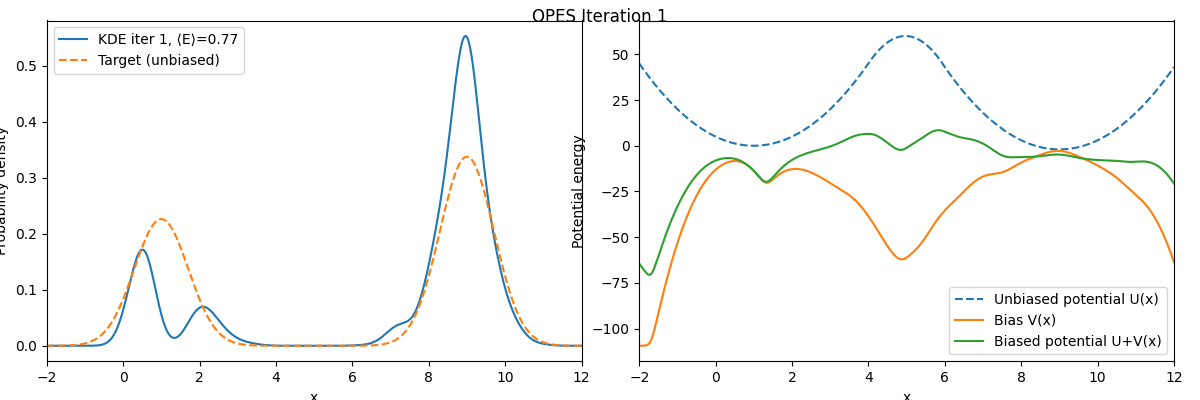

In [9]:
from IPython.display import Image, display

display(Image(filename="../gif/opes_evolution.gif"))

As we can see, the bias potential quickly becomes quasi-static, which is one of the main advantages of **OPES**. Compared to **well-tempered metadynamics (WT-MetaD)**, which also aims to sample from a well-tempered distribution, OPES is generally more robust and achieves convergence faster. Moreover, OPES requires fewer parameters to tune, and the **reweighting procedure** is straightforward. In contrast, in WT-MetaD the bias continuously evolves over time, making accurate reweighting more challenging and requiring additional considerations.


#### Conclusion

In this post, we explored how **on-the-fly probability enhanced sampling (OPES)** enables efficient sampling of free energy landscapes. Starting from the fundamental idea of biasing the collective variable (CV) distribution toward a target (e.g., well-tempered) distribution, we derived how the bias potential can be constructed iteratively from on-the-fly estimates of the CV probability.

We demonstrated that OPES achieves rapid convergence, producing accurate free energy profiles that agree well with the exact results. Unlike **well-tempered metadynamics (WT-MetaD)**, OPES yields a nearly static bias very fast, making reweighting straightforward and reducing the number of parameters that need tuning.

In practice, OPES is conveniently implemented in the **[PLUMED](https://www.plumed.org/doc-v2.10/user-doc/html/_o_p_e_s__m_e_t_a_d.html)** library, allowing it to be easily coupled with most molecular dynamics engines. Overall, OPES provides a **conceptually simple, computationally efficient, and robust** framework for enhanced sampling. 
